In [19]:
import os, random, PIL
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import v2

import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

num_suits = 4
num_cards_per_suit = 13
num_cards = 52

NEGATIVE_INDEX = num_cards
MOVING_INDEX = num_cards+1
NEGATIVE_SUIT = num_suits
MOVING_SUIT = num_suits+1
NEGATIVE_CARD = num_cards_per_suit
MOVING_CARD = num_cards_per_suit+1

card_w = 50
card_h = 120

suit_names = ['Clubs', 'Diamonds', 'Hearts', 'Spades', 'Negative', 'Moving']
card_names = [ '2', '3', '4', '5', '6', '7', '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace', 'Negative', 'Moving']
full_names = [f"{c} of {s}" for s in suit_names[:-2] for c in card_names[:-2]] + ['Negative', 'Moving']

In [15]:
# convert overview to card images
from pathlib import Path
if True:
    off = 20
    for dp, dn, fn in os.walk("data/originals"):
        for i, f in enumerate(fn):
            if not f.endswith(".jpg"):
                continue
            path = os.path.join(dp, f)
            print(f"processing {path} -> {off+i}")
            org = np.array(PIL.Image.open(path))
            for s in range(0, 4):
                for c in range(0, 13):
                    card = org[s*card_h:(s+1)*card_h, c*card_w:(c+1)*card_w]
                    card = PIL.Image.fromarray(card)
                    card.save(f"data/staging/{s}_{c}_{off+i}.png")
            if org.shape[1] == 14*card_w:
                card = org[3*card_h:(4*card_h), 13*card_w:(14*card_w)]
                card = PIL.Image.fromarray(card)
                card.save(f"data/staging/NEG_{off+i}.png")
            

processing data/originals/overview (10).jpg -> 21
processing data/originals/overview (8).jpg -> 22
processing data/originals/overview (9).jpg -> 23


In [47]:
class CardDataset(Dataset):
    def __init__(self, path:str):
        self.path = path
        self.data = []
        self.cache = {}
        negcount = 0
        movcount = 0
        for dp, dn, fn in os.walk(path):
            for f in fn:
                if f.endswith(".png"):
                    if f.startswith("NEG_"):
                        index = NEGATIVE_INDEX
                        suit = NEGATIVE_SUIT
                        card = NEGATIVE_CARD
                        negcount += 1
                    elif f.startswith("MOV_"):
                        index = MOVING_INDEX
                        suit = MOVING_SUIT
                        card = MOVING_CARD
                        movcount += 1
                    else:
                        suit = int(f.split("_")[0])
                        card = int(f.split("_")[1])
                        index = card + suit * num_cards_per_suit
                    self.data.append((os.path.join(dp, f), suit, card, index))
        random.shuffle(self.data)
        print(f"Loaded {len(self.data)} images, {negcount} negative, {movcount} moving samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        path, suit, card, index = self.data[idx]
        image = PIL.Image.open(path)
        image = np.array(image).reshape(card_h, card_w, 1)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0 - 0.5
        row = {'image':image, 'suit':suit, 'card':card, 'index':index}
        self.cache[idx] = row
        return row

ds = CardDataset("data/cards")

Loaded 576 images, 11 negative, 65 moving samples


In [48]:
n = len(ds) // 10
batch_size = 16
evalset = Subset(ds, range(n))
trainset = Subset(ds, range(n, len(ds)))
evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True, num_workers=0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f"Train: {len(trainset)} Eval: {len(evalset)}")

Train: 519 Eval: 57


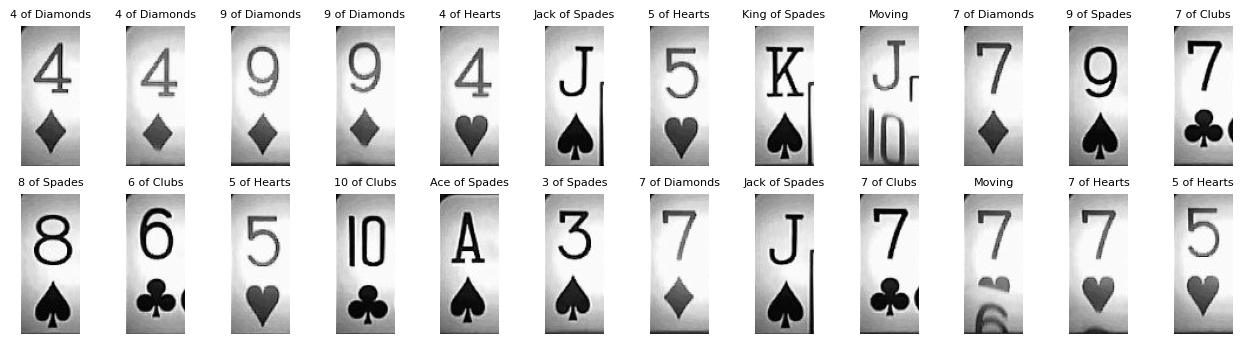

In [49]:
def toimg(tensor):
    return tensor.permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(16, 4))
for i, row in enumerate(Subset(ds, np.arange(0, 24))):
    ax = plt.subplot(2, 12, i + 1)
    plt.imshow(toimg(row['image']), cmap='gray')
    #plt.imshow(image)
    plt.title(full_names[row['index']], fontsize=8)
    plt.axis("off")

In [50]:
class CardModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.conv2 = nn.Conv2d(3, 8, 3)
        self.conv3 = nn.Conv2d(8, 16, 3)
        #self.drop = nn.Dropout2d(0.1)
        self.fc = nn.Linear(16*13*4, (num_suits + 2) + (num_cards_per_suit + 2))

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape)
        #x = self.drop(x)
        x = torch.flatten(x, 1)
        return self.fc(x)   

    def num_params(self):
        total = 0
        for p in self.parameters():
            total += p.numel()
        return total

    def predict(self, image):
        #image = image.float().permute((0, 3, 1, 2)) / 255.0 - 0.5
        logits = model(image)
        suit = torch.argmax(logits[:, :6], dim=1)  
        card = torch.argmax(logits[:, 6:], dim=1)
        index = suit*13 + card
        index[suit == NEGATIVE_SUIT] = NEGATIVE_INDEX
        index[card == NEGATIVE_CARD] = NEGATIVE_INDEX
        index[suit == MOVING_SUIT] = MOVING_INDEX
        index[card == MOVING_CARD] = MOVING_INDEX
        return index

model = CardModel()
print(f"number of parameters {model.num_params():,}")
index = model.predict(torch.randn(1, 1, card_h, card_w))

number of parameters 18,915


In [51]:
model

CardModel(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc): Linear(in_features=832, out_features=21, bias=True)
)

In [52]:
transforms = v2.Compose([
    v2.Pad(10, padding_mode='edge'),
    v2.RandomCrop(size=(card_h, card_w)),
    v2.RandomRotation(2),
])

In [53]:
model = CardModel()
num_epochs = 250
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

accuracy_history = []
loss_history = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, row in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        image = row['image']
        #image = image.float().permute((0, 3, 1, 2)) / 255.0 - 0.5
        image = transforms(image)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        logits = model(image)
        
        loss = loss_fn(logits[:,:6], row['suit']) + loss_fn(logits[:,6:], row['card'])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with torch.no_grad():
        eval_count = 0
        eval_correct = 0
        for i, row in enumerate(evalloader, 0):
            index = model.predict(row['image'])
            eval_count += len(index)
            eval_correct += torch.sum(index == row['index'])

    running_loss = running_loss / len(trainloader)
    accuracy = 100*eval_correct / eval_count
    accuracy_history.append(accuracy)
    loss_history.append(running_loss)

    if epoch % 10 == 0:
        print(f"{epoch:3d}: loss: {running_loss:.3f}, accuracy: {accuracy:.1f}%")

print('Finished Training')  

  0: loss: 4.381, accuracy: 7.0%
 10: loss: 2.191, accuracy: 73.7%
 20: loss: 1.364, accuracy: 84.2%
 30: loss: 0.814, accuracy: 98.2%
 40: loss: 0.548, accuracy: 96.5%
 50: loss: 0.298, accuracy: 100.0%
 60: loss: 0.253, accuracy: 98.2%
 70: loss: 0.164, accuracy: 100.0%
 80: loss: 0.172, accuracy: 100.0%
 90: loss: 0.137, accuracy: 100.0%
100: loss: 0.091, accuracy: 100.0%
110: loss: 0.102, accuracy: 100.0%
120: loss: 0.080, accuracy: 100.0%
130: loss: 0.096, accuracy: 100.0%
140: loss: 0.086, accuracy: 100.0%
150: loss: 0.169, accuracy: 100.0%
160: loss: 0.104, accuracy: 100.0%
170: loss: 0.058, accuracy: 100.0%
180: loss: 0.080, accuracy: 100.0%
190: loss: 0.086, accuracy: 98.2%
200: loss: 0.048, accuracy: 100.0%
210: loss: 0.067, accuracy: 96.5%
220: loss: 0.053, accuracy: 98.2%
230: loss: 0.089, accuracy: 100.0%
240: loss: 0.073, accuracy: 100.0%
Finished Training


<Figure size 500x200 with 0 Axes>

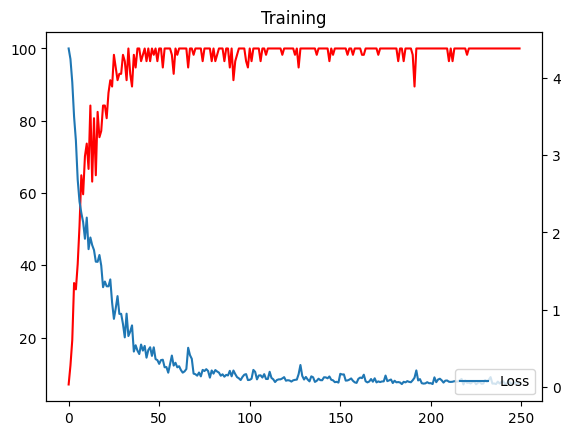

In [54]:
plt.figure(figsize=(5, 2))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(len(accuracy_history)), accuracy_history, label='Accuracy', color='r')
ax2.plot(range(len(loss_history)), loss_history, label='Loss')
plt.legend(loc='lower right')
plt.title('Training')
plt.show()

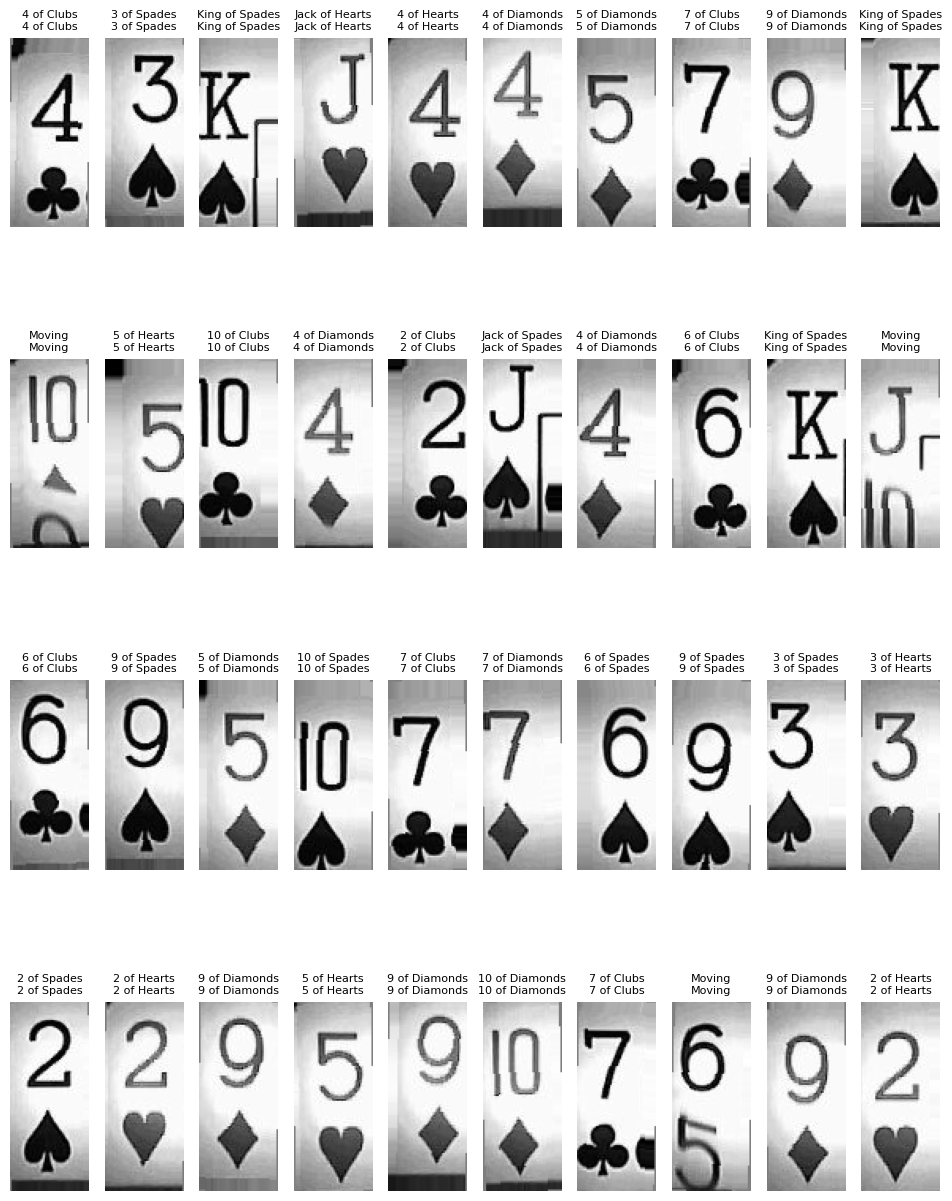

In [55]:
plt.figure(figsize=(12, 16))
ncols = 10
nrows = 4
i = 0
for row in evalloader:
    for image, index in zip(row['image'], row['index']):
        if i >= ncols * nrows:
            break
        image = image[None, ...]
        image = transforms(image)
        pred_index = model.predict(image)
        result = "WRONG\n" if pred_index != index else ""
        ax = plt.subplot(nrows, ncols, i + 1)
        plt.imshow(toimg(image[0]), cmap='gray')
        #plt.imshow(image)
        plt.title(f"{result}{full_names[pred_index]}\n{full_names[index]}", fontsize=8)
        plt.axis("off")
        #print(i, index, pred_index)
        i += 1


In [56]:
name = "card_model"

import onnx
input_shape = (1, 1, card_h, card_w)
torch.onnx.export(model, torch.randn(*input_shape), f"{name}.onnx", verbose=True, input_names=['input'], output_names=['output'])

import onnx_tf
onnx_model = onnx.load(f"{name}.onnx")
tf_model = onnx_tf.backend.prepare(onnx_model)
tf_model.export_graph(f"{name}.tf")

import tensorflow as tf

def representative_dataset():
  for data in Subset(ds, np.arange(0, 200)):
    yield {
      #"input": (data['image'] * 128).type(torch.int8),
      "input": data['image'],
      "bias": 0,
    }

converter = tf.lite.TFLiteConverter.from_saved_model(f"{name}.tf")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_model = converter.convert()

with open(f"{name}.tflite", 'wb') as f:
    f.write(tflite_model)

!xxd -i {name}.tflite > ../src/camera/card_model.h

INFO:absl:Function `__call__` contains input name(s) x with unsupported characters which will be renamed to transpose_15_x in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


Exported graph: graph(%input : Float(1, 1, 120, 50, strides=[6000, 6000, 50, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(3, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(3, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(8, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(8, strides=[1], requires_grad=1, device=cpu),
      %conv3.weight : Float(16, 8, 3, 3, strides=[72, 9, 3, 1], requires_grad=1, device=cpu),
      %conv3.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %fc.weight : Float(21, 832, strides=[832, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(21, strides=[1], requires_grad=1, device=cpu)):
  %/conv1/Conv_output_0 : Float(1, 3, 118, 48, strides=[16992, 5664, 48, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[0, 0, 0, 0], strides=[1, 1], onnx_name="/conv1/Conv"](%input, %conv

INFO:tensorflow:Assets written to: card_model.tf/assets
INFO:absl:Writing fingerprint to card_model.tf/fingerprint.pb
2024-03-26 21:13:53.376533: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-26 21:13:53.376546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-26 21:13:53.376644: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: card_model.tf
2024-03-26 21:13:53.376893: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-26 21:13:53.376897: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: card_model.tf
2024-03-26 21:13:53.377490: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-26 21:13:53.381982: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: card_model.tf
2024-03-26 21:13:53.385717: I t